In [1]:
#importing libraries

import numpy as np
import pandas as pd
import sqlite3
from pathlib import Path
from datetime import datetime, date 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import squarify 
import plotly.express as px
import warnings; warnings.simplefilter('ignore')

In [2]:
#creating empty database

Path('project.db').touch()

In [3]:
#creating database connection and cursor

conn = sqlite3.connect('project.db')
c = conn.cursor()

In [4]:
#creating first table ('people')

c.execute('''CREATE TABLE IF NOT EXISTS people (playerID text, birthYear text, birthMonth text, birthDay text, birthCountry text, birthState text, birthCity text, deathYear text, deathMonth text, deathDay text, deathCountry text, deathState text, deathCity text, nameFirst text, nameLast text, nameGiven text, weight int, height text, bats text, throws text, debut text, finalGame text, retroID text, bbrefID text
)''');

In [5]:
#loading CSV to people table

people= pd.read_csv('C:/Users/colin/OneDrive/Desktop/baseballdatabank-2023.1/core/People.csv')
people.to_sql('people', conn, if_exists='replace', index= False);

In [6]:
#creating second table ('batting')

c.execute('''CREATE TABLE IF NOT EXISTS batting (playerID text, yearID int, stint text, teamID text, lgID text, G int, AB int, R int, H int, '2B' int, '3B' int, HR int, RBI int, SB int, CS int, BB int, SO int, IBB int, HBP int, SH int, SF int, GIDP int
)''');

In [7]:
#loading CSV to batting table

batting= pd.read_csv('C:/Users/colin/OneDrive/Desktop/baseballdatabank-2023.1/core/Batting.csv')
batting.to_sql('batting', conn, if_exists='replace', index= False);

In [8]:
#joining tables from database, filtering, and converting to df

sql_df = pd.read_sql(
'''SELECT p.playerID, p.birthYear, p.birthMonth, p.birthDay, p.birthCountry, p.birthState, p.birthCity, p.nameFirst, p.nameLast, p.weight, p.bats, p.throws, p.finalGame,
b.yearID, b.stint, b.teamID, b.lgID, b.G, b.AB, b.R, b.H, b.[2B], b.[3B], b.HR, b.RBI, b.SB, b.CS, b.BB, b.SO, b.IBB, b.HBP, b.SH, b.SF, b.GIDP
FROM People p
JOIN Batting b
ON p.playerID = b.playerID
WHERE b.G >= 50 
AND p.finalGame BETWEEN '2022-10-01' AND '2022-10-31' 
AND b.AB != 0''', conn)
conn.close()

display(sql_df)

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,nameFirst,nameLast,weight,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,pujolal01,1980.0,1.0,16.0,D.R.,Distrito Nacional,Santo Domingo,Albert,Pujols,235.0,...,130.0,1.0,3.0,69,93.0,6.0,9.0,1.0,7.0,21.0
1,pujolal01,1980.0,1.0,16.0,D.R.,Distrito Nacional,Santo Domingo,Albert,Pujols,235.0,...,127.0,2.0,4.0,72,69.0,13.0,9.0,0.0,4.0,20.0
2,cabremi01,1983.0,4.0,18.0,Venezuela,Aragua,Maracay,Miguel,Cabrera,267.0,...,62.0,0.0,2.0,25,84.0,3.0,2.0,4.0,1.0,12.0
3,pujolal01,1980.0,1.0,16.0,D.R.,Distrito Nacional,Santo Domingo,Albert,Pujols,235.0,...,124.0,5.0,1.0,79,65.0,12.0,10.0,0.0,5.0,13.0
4,cabremi01,1983.0,4.0,18.0,Venezuela,Aragua,Maracay,Miguel,Cabrera,267.0,...,112.0,5.0,2.0,68,148.0,5.0,6.0,0.0,8.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,wynnsau01,1990.0,12.0,10.0,USA,CA,San Diego,Austin,Wynns,190.0,...,21.0,0.0,0.0,10,38.0,0.0,3.0,1.0,1.0,9.0
1629,yastrmi01,1990.0,8.0,23.0,USA,MA,Andover,Mike,Yastrzemski,178.0,...,57.0,5.0,1.0,61,141.0,0.0,5.0,1.0,6.0,3.0
1630,yelicch01,1991.0,12.0,5.0,USA,CA,Thousand Oaks,Christian,Yelich,195.0,...,57.0,19.0,3.0,88,162.0,5.0,5.0,1.0,2.0,9.0
1631,yepezju01,1998.0,2.0,19.0,Venezuela,Distrito Federal,Caracas,Juan,Yepez,200.0,...,30.0,0.0,0.0,16,61.0,0.0,1.0,0.0,4.0,6.0


In [9]:
#creating new name and age columns

sql_df = sql_df.astype({'birthYear': 'int', 'birthMonth': 'int', 'birthDay': 'int'})
cols=['birthYear','birthMonth','birthDay']
sql_df['birthDate'] = sql_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
sql_df = sql_df.astype({'birthDate': 'str'})

def age(born): 
    born = datetime.strptime(born, '%Y-%m-%d').date() 
    today = date.today() 
    return today.year - born.year - ((today.month,  
                                      today.day) < (born.month,  
                                                    born.day)) 
sql_df['Age'] = sql_df['birthDate'].apply(age) 

sql_df['Name'] = sql_df['nameFirst'] +' '+ sql_df['nameLast']


display(sql_df)


,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,nameFirst,nameLast,weight,...,BB,SO,IBB,HBP,SH,SF,GIDP,birthDate,Age,Name
0,pujolal01,1980,1,16,D.R.,Distrito Nacional,Santo Domingo,Albert,Pujols,235.0,...,69,93.0,6.0,9.0,1.0,7.0,21.0,1980-1-16,43,Albert Pujols
1,pujolal01,1980,1,16,D.R.,Distrito Nacional,Santo Domingo,Albert,Pujols,235.0,...,72,69.0,13.0,9.0,0.0,4.0,20.0,1980-1-16,43,Albert Pujols
2,cabremi01,1983,4,18,Venezuela,Aragua,Maracay,Miguel,Cabrera,267.0,...,25,84.0,3.0,2.0,4.0,1.0,12.0,1983-4-18,40,Miguel Cabrera
3,pujolal01,1980,1,16,D.R.,Distrito Nacional,Santo Domingo,Albert,Pujols,235.0,...,79,65.0,12.0,10.0,0.0,5.0,13.0,1980-1-16,43,Albert Pujols
4,cabremi01,1983,4,18,Venezuela,Aragua,Maracay,Miguel,Cabrera,267.0,...,68,148.0,5.0,6.0,0.0,8.0,20.0,1983-4-18,40,Miguel Cabrera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,wynnsau01,1990,12,10,USA,CA,San Diego,Austin,Wynns,190.0,...,10,38.0,0.0,3.0,1.0,1.0,9.0,1990-12-10,33,Austin Wynns
1629,yastrmi01,1990,8,23,USA,MA,Andover,Mike,Yastrzemski,178.0,...,61,141.0,0.0,5.0,1.0,6.0,3.0,1990-8-23,33,Mike Yastrzemski
1630,yelicch01,1991,12,5,USA,CA,Thousand Oaks,Christian,Yelich,195.0,...,88,162.0,5.0,5.0,1.0,2.0,9.0,1991-12-5,32,Christian Yelich
1631,yepezju01,1998,2,19,Venezuela,Distrito Federal,Caracas,Juan,Yepez,200.0,...,16,61.0,0.0,1.0,0.0,4.0,6.0,1998-2-19,25,Juan Yepez


In [10]:
#dropping old columns

sql_df = sql_df.drop(['birthYear', 'birthMonth', 'birthDay', 'nameFirst', 'nameLast', 'birthDate'], axis=1)


In [11]:
#moving new columns

col = sql_df.pop('Name')
sql_df.insert(1, col.name, col)
col2 = sql_df.pop('Age')
sql_df.insert(2, col2.name,col2)
display(sql_df)

,playerID,Name,Age,birthCountry,birthState,birthCity,weight,bats,throws,finalGame,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,pujolal01,Albert Pujols,43,D.R.,Distrito Nacional,Santo Domingo,235.0,R,R,2022-10-04,...,130.0,1.0,3.0,69,93.0,6.0,9.0,1.0,7.0,21.0
1,pujolal01,Albert Pujols,43,D.R.,Distrito Nacional,Santo Domingo,235.0,R,R,2022-10-04,...,127.0,2.0,4.0,72,69.0,13.0,9.0,0.0,4.0,20.0
2,cabremi01,Miguel Cabrera,40,Venezuela,Aragua,Maracay,267.0,R,R,2022-10-04,...,62.0,0.0,2.0,25,84.0,3.0,2.0,4.0,1.0,12.0
3,pujolal01,Albert Pujols,43,D.R.,Distrito Nacional,Santo Domingo,235.0,R,R,2022-10-04,...,124.0,5.0,1.0,79,65.0,12.0,10.0,0.0,5.0,13.0
4,cabremi01,Miguel Cabrera,40,Venezuela,Aragua,Maracay,267.0,R,R,2022-10-04,...,112.0,5.0,2.0,68,148.0,5.0,6.0,0.0,8.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,wynnsau01,Austin Wynns,33,USA,CA,San Diego,190.0,R,R,2022-10-04,...,21.0,0.0,0.0,10,38.0,0.0,3.0,1.0,1.0,9.0
1629,yastrmi01,Mike Yastrzemski,33,USA,MA,Andover,178.0,L,L,2022-10-05,...,57.0,5.0,1.0,61,141.0,0.0,5.0,1.0,6.0,3.0
1630,yelicch01,Christian Yelich,32,USA,CA,Thousand Oaks,195.0,L,R,2022-10-05,...,57.0,19.0,3.0,88,162.0,5.0,5.0,1.0,2.0,9.0
1631,yepezju01,Juan Yepez,25,Venezuela,Distrito Federal,Caracas,200.0,R,R,2022-10-05,...,30.0,0.0,0.0,16,61.0,0.0,1.0,0.0,4.0,6.0


In [12]:
#changing column names to look better

pd.set_option('display.max_columns', None)

sql_df.rename(columns={'playerID': 'Player ID', 'birthCountry' : 'Birth Country', 'birthState' : 'Birth State', 'birthCity' : 'Birth City', 'weight' : 'Weight', 'bats' : 'Bats', 'throws' : 'Throws','finalGame' : 'Final Game',
                    'yearID' : 'Year ID', 'stint' : 'Stint', 'teamID' : 'Team',  'lgID' : 'League', 'G' : 'Games Played', 
                    'AB' : 'At Bats', 'R' : 'Runs', 'H' : 'Hits', '2B' : 'Doubles', '3B' : 'Triples', 'HR' : 'Home Runs', 'RBI' : 'Runs Batted In', 'SB' : 'Stolen Bases', 'CS' : 'Caught Stealing', 'BB' : 'Base on Balls', 'SO' : 'Strike Outs', 'IBB'	: 'Intentional Walks', 'HBP' : 'Hit by Pitch', 'SH' : 'Sacrifice Hits',	'SF' : 'Sacrifice Flies' ,	'GIDP' : 'Grounded Double'      
                    }, inplace=True)

display(sql_df)

,Player ID,Name,Age,Birth Country,Birth State,Birth City,Weight,Bats,Throws,Final Game,Year ID,Stint,Team,League,Games Played,At Bats,Runs,Hits,Doubles,Triples,Home Runs,Runs Batted In,Stolen Bases,Caught Stealing,Base on Balls,Strike Outs,Intentional Walks,Hit by Pitch,Sacrifice Hits,Sacrifice Flies,Grounded Double
0,pujolal01,Albert Pujols,43,D.R.,Distrito Nacional,Santo Domingo,235.0,R,R,2022-10-04,2001,1,SLN,NL,161,590,112,194,47,4,37,130.0,1.0,3.0,69,93.0,6.0,9.0,1.0,7.0,21.0
1,pujolal01,Albert Pujols,43,D.R.,Distrito Nacional,Santo Domingo,235.0,R,R,2022-10-04,2002,1,SLN,NL,157,590,118,185,40,2,34,127.0,2.0,4.0,72,69.0,13.0,9.0,0.0,4.0,20.0
2,cabremi01,Miguel Cabrera,40,Venezuela,Aragua,Maracay,267.0,R,R,2022-10-04,2003,1,FLO,NL,87,314,39,84,21,3,12,62.0,0.0,2.0,25,84.0,3.0,2.0,4.0,1.0,12.0
3,pujolal01,Albert Pujols,43,D.R.,Distrito Nacional,Santo Domingo,235.0,R,R,2022-10-04,2003,1,SLN,NL,157,591,137,212,51,1,43,124.0,5.0,1.0,79,65.0,12.0,10.0,0.0,5.0,13.0
4,cabremi01,Miguel Cabrera,40,Venezuela,Aragua,Maracay,267.0,R,R,2022-10-04,2004,1,FLO,NL,160,603,101,177,31,1,33,112.0,5.0,2.0,68,148.0,5.0,6.0,0.0,8.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,wynnsau01,Austin Wynns,33,USA,CA,San Diego,190.0,R,R,2022-10-04,2022,1,SFN,NL,66,162,14,42,7,0,3,21.0,0.0,0.0,10,38.0,0.0,3.0,1.0,1.0,9.0
1629,yastrmi01,Mike Yastrzemski,33,USA,MA,Andover,178.0,L,L,2022-10-05,2022,1,SFN,NL,148,485,73,104,31,2,17,57.0,5.0,1.0,61,141.0,0.0,5.0,1.0,6.0,3.0
1630,yelicch01,Christian Yelich,32,USA,CA,Thousand Oaks,195.0,L,R,2022-10-05,2022,1,MIL,NL,154,575,99,145,25,4,14,57.0,19.0,3.0,88,162.0,5.0,5.0,1.0,2.0,9.0
1631,yepezju01,Juan Yepez,25,Venezuela,Distrito Federal,Caracas,200.0,R,R,2022-10-05,2022,1,SLN,NL,76,253,27,64,13,0,12,30.0,0.0,0.0,16,61.0,0.0,1.0,0.0,4.0,6.0


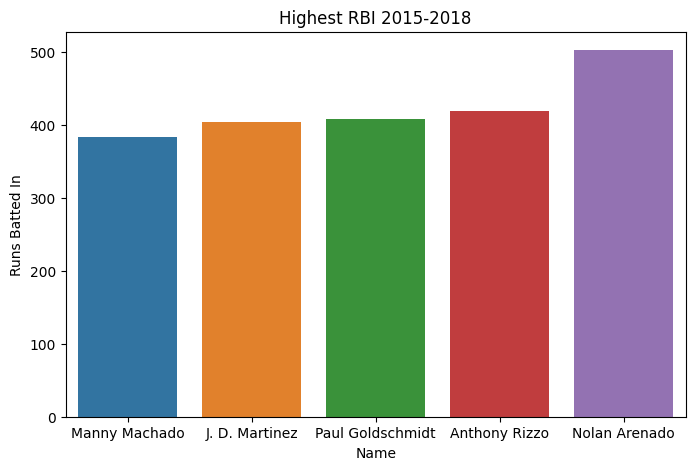

In [13]:
#Highest RBI in 2015-2018?

rbi1518 = [2015, 2016, 2017, 2018]
df1518 = sql_df[sql_df['Year ID'].isin(rbi1518) == True]
agg_functions = {'Name': 'first', 'Runs Batted In': 'sum', }
new_df1518 = df1518.groupby(df1518['Player ID']).aggregate(agg_functions)
rbi_sql_df = new_df1518.sort_values(by=['Runs Batted In']).tail(5)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x = 'Name', y = 'Runs Batted In',data = rbi_sql_df).set(title = 'Highest RBI 2015-2018');


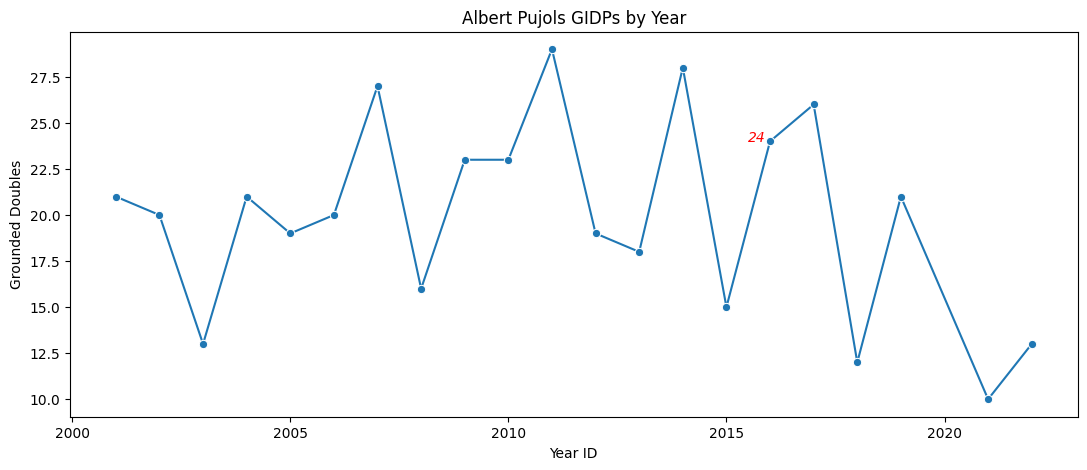

In [14]:
#Albert Pujols GIDPs in 2016?

ap = sql_df[sql_df['Name'] == 'Albert Pujols']

fig, ax = plt.subplots(figsize=(13, 5))
sns.lineplot(data= ap, x='Year ID', y='Grounded Double', marker = 'o')
plt.xlabel('Year ID')
plt.ylabel('Grounded Doubles')
plt.title('Albert Pujols GIDPs by Year')
ax.text(2015.5, 24, '24', fontsize = 10,
       fontstyle = 'oblique',
       color = 'red')
plt.show()
 

In [15]:
#calculating triples per year

triples = sql_df.groupby('Year ID')['Triples'].sum()
display(triples)

Year ID
2001      4
2002      2
2003      4
2004      3
2005      5
2006      3
2007      3
2008      5
2009     20
2010     18
2011     25
2012     67
2013    100
2014    164
2015    231
2016    248
2017    281
2018    342
2019    377
2020    101
2021    410
2022    484
Name: Triples, dtype: int64

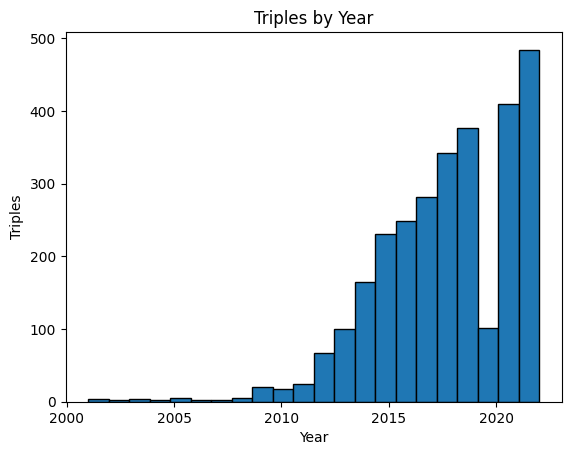

In [16]:
#histogram of triples by year

trips_by_year = [[2001] * 4 + [2002] * 2 + [2003] * 4 + [2004] * 3 + [2005] * 5 + [2006] * 3 + [2007] * 3 + [2008] * 5 + [2009] * 20 + [2010] * 18 + 
[2011] * 25 + [2012] * 67 + [2013] * 100 + [2014] * 164 + [2015] * 231 + [2016] * 248 + [2017] * 281 + [2018] * 342 + [2019] * 377 + [2020] *101 + 
[2021] * 410 + [2022] * 484] 

plt.hist(trips_by_year, bins=22, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Triples')
plt.title('Triples by Year')
plt.show()

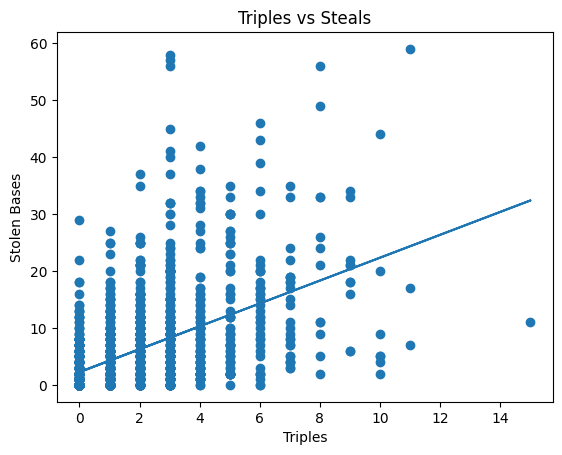

In [17]:
#scatterplot of triples and steals

plt.scatter(sql_df['Triples'], sql_df['Stolen Bases'])
m, b = np.polyfit(sql_df['Triples'], sql_df['Stolen Bases'], 1)
plt.plot(sql_df['Triples'], m*sql_df['Triples']+b)
plt.title('Triples vs Steals')
plt.xlabel('Triples')
plt.ylabel('Stolen Bases');

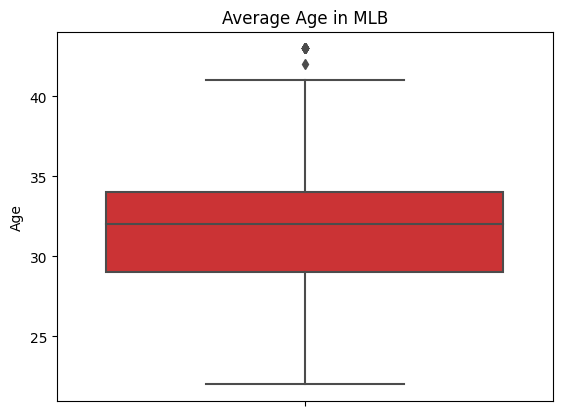

In [18]:
#what's the average age range of active players in MLB

sns.boxplot(y = 'Age', data = sql_df, palette='Set1').set(
    title = 'Average Age in MLB');

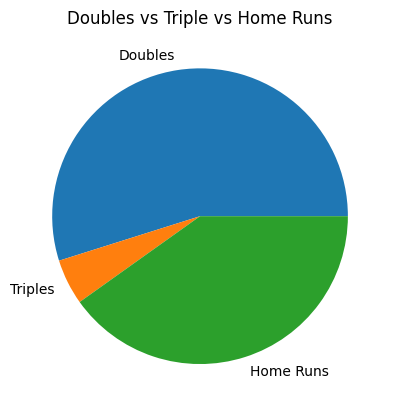

In [19]:
#were doubles, triples or home runs highest?

double_sum = sql_df['Doubles'].sum()
triple_sum = sql_df['Triples'].sum()
hr_sum = sql_df['Home Runs'].sum()
labels = ['Doubles', 'Triples', 'Home Runs']
sum = [double_sum, triple_sum, hr_sum]

plt.pie(sum, labels = labels)
plt.title('Doubles vs Triple vs Home Runs');


In [20]:
#what US state had highest number of MLB players?

us_df = sql_df[sql_df['Birth Country'] == 'USA']
us_df['State Count'] = us_df.groupby('Birth State')['Birth State'].transform ('count')
px.choropleth(us_df, locations='Birth State',
                    locationmode='USA-states',
                    color='State Count',
                    scope = 'usa',
                    color_continuous_scale=px.colors.sequential.Blues,
                    title = 'MLB Players by State')

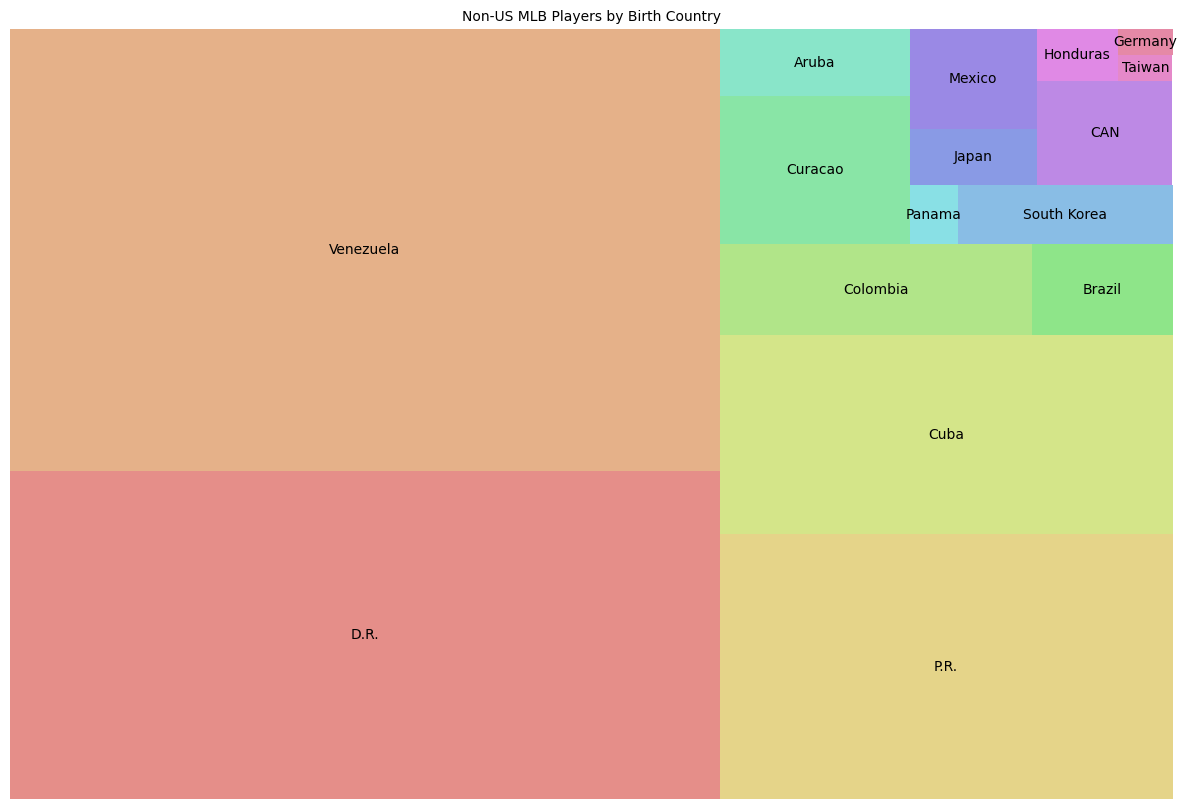

In [21]:
#what country outside the US had highest number of MLB players?

world_df = sql_df[sql_df['Birth Country'] != 'USA']
world_df['Country Count'] = world_df.groupby('Birth Country')['Birth Country'].transform ('count')
mlb_world = world_df.drop_duplicates(subset=['Birth Country'])
fig, ax = plt.subplots(figsize=(15, 10))
squarify.plot(sizes = mlb_world['Country Count'], label= mlb_world['Birth Country'],
                text_kwargs = {'fontsize': 10, 'color': 'black'}, color = sns.color_palette('hls', 
                                     len(mlb_world)), alpha = 0.7)
plt.title('Non-US MLB Players by Birth Country', fontsize= 10)
plt.axis('off');

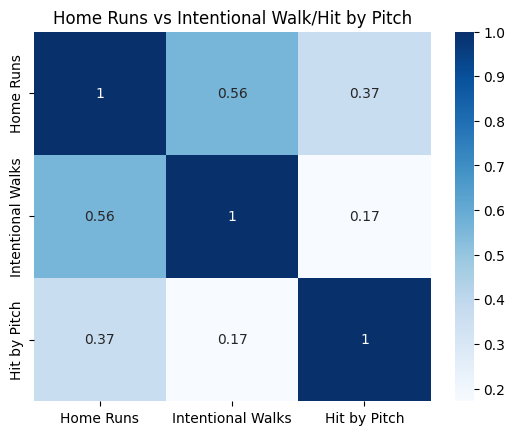

In [23]:
#as home runs increase, is player more likely to get hit by a pitch or intentionally walked?

mlb_hm = sql_df[['Home Runs', 'Intentional Walks', 'Hit by Pitch']]
sns.heatmap(mlb_hm.corr(), cmap = 'Blues', annot = True)
plt.title('Home Runs vs Intentional Walk/Hit by Pitch');